In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import io
import requests
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping


pd.set_option('display.max_colwidth',1000)
from tensorflow.keras.utils import get_file

try:
    path = get_file('kddcup.data_10_percent.gz', origin=
    'http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')
except:
    print('Encountered error while downloading')
    raise

print(path)
dataset = pd.read_csv(path, header=None)

print("Read {} rows.".format(len(dataset)))

dataset.dropna(inplace=True,axis=1)
#Add column names - based on http://kdd.ics.uci.edu/databases/kddcup99/task.html
column_names = ['duration',
                'protocol_type',
                'service',
                'flag',
                'src_bytes',
                'dst_bytes',
                'land',
                'wrong_fragment',
                'urgent',
                'hot',
                'num_failed_logins',
                'logged_in',
                'num_compromised',
                'root_shell',
                'su_attempted',
                'num_root',
                'num_file_creations',
                'num_shells',
                'num_access_files',
                'num_outbound_cmds',
                'is_host_login',
                'is_guest_login',
                'count',
                'srv_count',
                'serror_rate',
                'srv_serror_rate',
                'rerror_rate',
                'srv_rerror_rate',
                'same_srv_rate',
                'diff_srv_rate',
                'srv_diff_host_rate',
                'dst_host_count',
                'dst_host_srv_count',
                'dst_host_same_srv_rate',
                'dst_host_diff_srv_rate',
                'dst_host_same_src_port_rate',
                'dst_host_srv_diff_host_rate',
                'dst_host_serror_rate',
                'dst_host_srv_serror_rate',
                'dst_host_rerror_rate',
                'dst_host_srv_rerror_rate',
                'Output Possibilities'
                ]

dataset = pd.read_csv(path, names = column_names)




/root/.keras/datasets/kddcup.data_10_percent.gz
Read 494021 rows.


In [13]:

dataset.head() #show the first 5 rows

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Output Possibilities
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [14]:
pd.set_option('display.max_rows', 99999)
pd.set_option('display.max_colwidth', 400)
# pd.describe_option('max_colwidth')

display.max_colwidth : int


dataset['Output Possibilities'].value_counts()

Output Possibilities
smurf.              280790
neptune.            107201
normal.              97278
back.                 2203
satan.                1589
ipsweep.              1247
portsweep.            1040
warezclient.          1020
teardrop.              979
pod.                   264
nmap.                  231
guess_passwd.           53
buffer_overflow.        30
land.                   21
warezmaster.            20
imap.                   12
rootkit.                10
loadmodule.              9
ftp_write.               8
multihop.                7
phf.                     4
perl.                    3
spy.                     2
Name: count, dtype: int64

In [15]:
#Visualisation in order to find correlation between input columns and output possibilities

def graph1(feature):

    labels = 'smurf', 'normal', 'other', 'neptune'
    sections = [107201, 97278, 2203+1589+1247+1040+1020+979+264+231+53+30+21+20+12+10+9+8+7+4+3+2, 280790]
    colors = ['c', 'g', 'y', 'b']

    plt.pie(sections, labels=labels, colors=colors,
           startangle=90,
           explode = (0, 0.1, 0, 0),
           autopct = '%1.2f%%') #how precise the percentage's going to be

    plt.axis('equal')
    plt.title('Output Possibilities')
    plt.show()


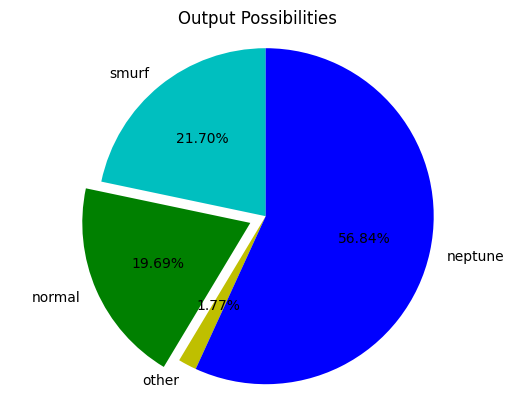

In [16]:
graph1('Output Possibilities')

In [17]:
#Data analysis
#based on https://www.youtube.com/watch?v=VgyKQ5MTDFc
#and https://sites.wustl.edu/jeffheaton/t81-558/
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore

def extend_categories(values): #the following function extends identified categories to show ncontinuous data
    result = []
    i = values.value_counts()
    j = float(len(values))
    for k in i.index:
        result.append("{}:{}%".format(k,round(100*(i[k]/j),2)))
    return "[{}]".format(",".join(result))

def understand(dataset): #the following function analyzes the dataset to find categorical data, if the data is not categorical it is extended to show how many different values can be identified in total
    print()
    columns = dataset.columns.values
    total = float(len(dataset))

    print("{} rows".format(int(total)))
    for col in columns:
        categorical = dataset[col].unique()
        categorical_count = len(categorical)
        if categorical_count>100:
            print("** {}:{} ({}%)".format(col,categorical_count,int(((categorical_count)/total)*100)))
        else:
            print("** {}:{}".format(col,extend_categories(dataset[col])))
            extend_categories(dataset[col])




In [18]:
 understand(dataset)
 #Determine whether the data is categorical or continuous
 #Categorical variables contain a finite number of categories or distinct groups. ...
 #Continuous variables are numeric variables that have an infinite number of values between any two values. A continuous variable can be numeric or date/time.

 #Later during the testing process, the continuous data (columns) can be removed as it's difficult to find correlation between the output possibility and the continuous data.
 #Patterns are more appealing to the eye, hence why using only categorical data makes more sense.


494021 rows
** duration:2495 (0%)
** protocol_type:[icmp:57.41%,tcp:38.47%,udp:4.12%]
** service:[ecr_i:56.96%,private:22.45%,http:13.01%,smtp:1.97%,other:1.46%,domain_u:1.19%,ftp_data:0.96%,eco_i:0.33%,ftp:0.16%,finger:0.14%,urp_i:0.11%,telnet:0.1%,ntp_u:0.08%,auth:0.07%,pop_3:0.04%,time:0.03%,csnet_ns:0.03%,remote_job:0.02%,gopher:0.02%,imap4:0.02%,discard:0.02%,domain:0.02%,iso_tsap:0.02%,systat:0.02%,shell:0.02%,echo:0.02%,rje:0.02%,whois:0.02%,sql_net:0.02%,printer:0.02%,nntp:0.02%,courier:0.02%,sunrpc:0.02%,netbios_ssn:0.02%,mtp:0.02%,vmnet:0.02%,uucp_path:0.02%,uucp:0.02%,klogin:0.02%,bgp:0.02%,ssh:0.02%,supdup:0.02%,nnsp:0.02%,login:0.02%,hostnames:0.02%,efs:0.02%,daytime:0.02%,link:0.02%,netbios_ns:0.02%,pop_2:0.02%,ldap:0.02%,netbios_dgm:0.02%,exec:0.02%,http_443:0.02%,kshell:0.02%,name:0.02%,ctf:0.02%,netstat:0.02%,Z39_50:0.02%,IRC:0.01%,urh_i:0.0%,X11:0.0%,tim_i:0.0%,pm_dump:0.0%,tftp_u:0.0%,red_i:0.0%]
** flag:[SF:76.6%,S0:17.61%,REJ:5.44%,RSTR:0.18%,RSTO:0.12%,SH:0.02%,S

In [19]:
# # Encode a numeric column as zscores
# def encode_numeric_withzscore(dataset, name, mean=None, sd=None):
#     if mean is None:
#         mean = dataset[name].mean()

#     if sd is None:
#         sd = dataset[name].std()

#     dataset[name] = (dataset[name] - mean) / sd

# # Encode text values to dummy variables(i.e. [1,0,0],
# # [0,1,0],[0,0,1] for red,green,blue)
# def encode_text_withdummy(dataset, name):
#     dummies = pd.get_dummies(dataset[name])
#     for x in dummies.columns:
#         dummy_name = f"{name}-{x}"
#         dataset[dummy_name] = dummies[x]
#     dataset.drop(name, axis=1, inplace=True)

In [20]:
# #encoding - less time efficient - good for comparison
# encode_numeric_withzscore(dataset, 'duration')
# encode_text_withdummy(dataset, 'protocol_type')
# encode_text_withdummy(dataset, 'service')
# encode_text_withdummy(dataset, 'flag')
# encode_numeric_withzscore(dataset, 'src_bytes')
# encode_numeric_withzscore(dataset, 'dst_bytes')
# encode_text_withdummy(dataset, 'land')
# encode_numeric_withzscore(dataset, 'wrong_fragment')
# encode_numeric_withzscore(dataset, 'urgent')
# encode_numeric_withzscore(dataset, 'hot')
# encode_numeric_withzscore(dataset, 'num_failed_logins')
# encode_text_withdummy(dataset, 'logged_in')
# encode_numeric_withzscore(dataset, 'num_compromised')
# encode_numeric_withzscore(dataset, 'root_shell')
# encode_numeric_withzscore(dataset, 'su_attempted')
# encode_numeric_withzscore(dataset, 'num_root')
# encode_numeric_withzscore(dataset, 'num_file_creations')
# encode_numeric_withzscore(dataset, 'num_shells')
# encode_numeric_withzscore(dataset, 'num_access_files')
# encode_numeric_withzscore(dataset, 'num_outbound_cmds')
# encode_text_withdummy(dataset, 'is_host_login')
# encode_text_withdummy(dataset, 'is_guest_login')
# encode_numeric_withzscore(dataset, 'count')
# encode_numeric_withzscore(dataset, 'srv_count')
# encode_numeric_withzscore(dataset, 'serror_rate')
# encode_numeric_withzscore(dataset, 'srv_serror_rate')
# encode_numeric_withzscore(dataset, 'rerror_rate')
# encode_numeric_withzscore(dataset, 'srv_rerror_rate')
# encode_numeric_withzscore(dataset, 'same_srv_rate')
# encode_numeric_withzscore(dataset, 'diff_srv_rate')
# encode_numeric_withzscore(dataset, 'srv_diff_host_rate')
# encode_numeric_withzscore(dataset, 'dst_host_count')
# encode_numeric_withzscore(dataset, 'dst_host_srv_count')
# encode_numeric_withzscore(dataset, 'dst_host_same_srv_rate')
# encode_numeric_withzscore(dataset, 'dst_host_diff_srv_rate')
# encode_numeric_withzscore(dataset, 'dst_host_same_src_port_rate')
# encode_numeric_withzscore(dataset, 'dst_host_srv_diff_host_rate')
# encode_numeric_withzscore(dataset, 'dst_host_serror_rate')
# encode_numeric_withzscore(dataset, 'dst_host_srv_serror_rate')
# encode_numeric_withzscore(dataset, 'dst_host_rerror_rate')
# encode_numeric_withzscore(dataset, 'dst_host_srv_rerror_rate')


# # Convert to numpy - Classification
# inputs_columns = dataset.columns.drop('Output Possibilities')
# inputs = dataset[inputs_columns].values
# dummies = pd.get_dummies(dataset['Output Possibilities']) # Classification
# outcomes = dummies.columns
# num_classes = len(outcomes)
# output = dummies.values

In [21]:
#encode - second variant - more time-efficient
#encode non-numerical input data
encoded_service = {'ecr_i':0, 'private':1, 'http':2, 'smtp':3, 'other':4, 'domain_u':5, 'ftp_data':6, 'eco_i':7, 'ftp':8, 'finger':9, 'urp_i':10, 'telnet':11, 'ntp_u':12, 'auth':13, 'pop_3':14, 'time':15, 'csnet_ns':16, 'remote_job':17, 'gopher':18, 'imap4':19, 'discard':20, 'domain':21, 'iso_tsap':22, 'systat':23, 'shell':24, 'echo':25, 'rje':26, 'sql_net':27, 'whois':28, 'printer':29, 'courier':30, 'nntp':31, 'sunrpc':32, 'mtp':33, 'netbios_ssn':34, 'bgp':35, 'uucp':36, 'vmnet':37, 'uucp_path':38, 'klogin':39, 'ssh':40, 'nnsp':41, 'supdup':42, 'login':43, 'hostnames':44, 'efs':45, 'daytime':46, 'netbios_ns':47, 'link':48, 'ldap':49, 'pop_2':50, 'exec':51, 'http_443':52, 'netbios_dgm':53, 'name':54, 'kshell':55, 'ctf':56, 'netstat':57, 'Z39_50':58, 'IRC':59, 'urh_i':60, 'X11':61, 'tim_i':62, 'tftp_u':63, 'pm_dump':64, 'red_i':65} #services and how they are encoded
dataset['service'] = dataset['service'].map(encoded_service) #mapping the service column's non-numerical values with numerical values pre-determined in the line above

encoded_protocols = {'icmp':0,'tcp':1,'udp':2} #protocol type and how they are encoded
dataset['protocol_type'] = dataset['protocol_type'].map(encoded_protocols) #mapping the protocol_type column's non-numerical values with numerical values pre-determined in the line above

encoded_flag = {'S0':0, 'S1':1, 'S2':2, 'S3':3, 'SF':4, 'SH':5, 'REJ':6, 'RSTR':7, 'RSTO':8, 'RSTOS0':9, 'OTH':10} #flags and how they are encoded
dataset['flag'] = dataset['flag'].map(encoded_flag) #mapping the flag column's non-numerical values with numerical values pre-determined in the line above


In [22]:
#encode non-numerical output data
encoded_output = {'smurf.':1, 'neptune.':1, 'normal.':0, 'back.':1, 'satan.':1, 'ipsweep.':1, 'portsweep.':1, 'warezclient.':1, 'teardrop.':1, 'pod.':1, 'nmap.':1, 'guess_passwd.':1, 'buffer_overflow.':1, 'land.':1, 'warezmaster.':1, 'imap.':1, 'rootkit.':1, 'loadmodule.':1, 'ftp_write.':1, 'multihop.':1, 'phf.':1, 'perl.':1, 'spy.':1} #output possibilities and how they are encoded
dataset['Output Possibilities'] = dataset['Output Possibilities'].map(encoded_output) #mapping the output column's non-numerical values with numerical values pre-determined in the line above

dataset['Output Possibilities'].value_counts()



Output Possibilities
1    396743
0     97278
Name: count, dtype: int64

In [23]:
#the non-numerical data can be omitted instead of encoding it to see if it'll affect the accuracy
dataset.drop('duration',axis = 1,inplace= True)
dataset.drop('protocol_type',axis = 1,inplace= True)
dataset.drop('service',axis = 1,inplace= True)
dataset.head()

,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Output Possibilities
0,4,181,5450,0,0,0,0,0,1,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,0
1,4,239,486,0,0,0,0,0,1,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0
2,4,235,1337,0,0,0,0,0,1,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0
3,4,219,1337,0,0,0,0,0,1,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0
4,4,217,2032,0,0,0,0,0,1,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0


In [24]:
output = dataset[['Output Possibilities']]
inputs = dataset.drop(['Output Possibilities',], axis=1)

scaler = MinMaxScaler() #This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.
#used to normalize the features of a model
#source - https://towardsdatascience.com/everything-you-need-to-know-about-min-max-normalization-in-python-b79592732b79
inputs = scaler.fit_transform(inputs)

In [25]:
Principal_Component_Analysis = PCA(n_components=38) #during experiments the number of components is changed
#reduce dimensionality for a classification model
#number of components between 1 and n
inputs = Principal_Component_Analysis.fit_transform(inputs) #based on https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [26]:
# Split test and train data

#inputs_train, inputs_test, output_train, output_test = train_test_split(inputs, output, test_size=0.15)
#inputs_train, inputs_test, output_train, output_test = train_test_split(inputs, output, test_size=0.25)
inputs_train, inputs_test, output_train, output_test = train_test_split(inputs, output, test_size=0.35)
#inputs_train, inputs_test, output_train, output_test = train_test_split(inputs, output, test_size=0.45)
#inputs_train, inputs_test, output_train, output_test = train_test_split(inputs, output, test_size=0.55)
#inputs_train, inputs_test, output_train, output_test = train_test_split(inputs, output, test_size=0.65)
#inputs_train, inputs_test, output_train, output_test = train_test_split(inputs, output, test_size=0.75)
#inputs_train, inputs_test, output_train, output_test = train_test_split(inputs, output, test_size=0.85)
#inputs_train, inputs_test, output_train, output_test = train_test_split(inputs, output, test_size=0.90)
print(inputs_train.shape, inputs_test.shape, output_train.shape, output_test.shape)

(321113, 38) (172908, 38) (321113, 1) (172908, 1)


In [27]:
model = Sequential()
#https://keras.io/guides/sequential_model/
model.add(Dense(10,input_shape=(38,),activation = 'relu',kernel_initializer='random_uniform'))
#https://keras.io/api/layers/initializers/
model.add(Dense(10,activation = 'relu',kernel_initializer='random_uniform'))
model.add(Dense(10,activation = 'relu',kernel_initializer='random_uniform'))
model.add(Dense(5,activation='softmax'))
#https://keras.io/api/layers/activations/
model.add(Dense(1,activation='sigmoid',kernel_initializer='random_uniform'))
#https://keras.io/api/layers/activations/

model.compile(loss ='binary_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
#https://keras.io/api/losses/probabilistic_losses/#categorical_crossentropy-function
#and
#https://keras.io/api/optimizers/
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3,
                        patience=5, verbose=1, mode='auto',
                           restore_best_weights=True)
show_training_process = model.fit(inputs_train, output_train, batch_size=128, epochs=100, validation_data=(inputs_test, output_test), callbacks=[monitor])
#overfitting is prevented by the
#early stopping function and batch_size parameter affects the time the net needs to be trained

#If validation loss >> training loss --> overfitting.
#If validation loss  > training loss --> some overfitting.
#If validation loss  < training loss --> some underfitting.
#If validation loss << training loss --> underfitting.



Epoch 1/100
2509/2509 [==============================] - 10s 3ms/step - loss: 0.2656 - accuracy: 0.9530 - val_loss: 0.1097 - val_accuracy: 0.9934
Epoch 2/100
2509/2509 [==============================] - 11s 4ms/step - loss: 0.0696 - accuracy: 0.9941 - val_loss: 0.0463 - val_accuracy: 0.9939
Epoch 3/100
2509/2509 [==============================] - 8s 3ms/step - loss: 0.0367 - accuracy: 0.9942 - val_loss: 0.0318 - val_accuracy: 0.9941
Epoch 4/100
2509/2509 [==============================] - 9s 4ms/step - loss: 0.0285 - accuracy: 0.9943 - val_loss: 0.0283 - val_accuracy: 0.9941
Epoch 5/100
2509/2509 [==============================] - 8s 3ms/step - loss: 0.0264 - accuracy: 0.9944 - val_loss: 0.0273 - val_accuracy: 0.9940
Epoch 6/100
2509/2509 [==============================] - 8s 3ms/step - loss: 0.0257 - accuracy: 0.9944 - val_loss: 0.0271 - val_accuracy: 0.9938
Epoch 7/100
2509/2509 [==============================] - 9s 3ms/step - loss: 0.0253 - accuracy: 0.9945 - val_loss: 0.0262 - val_

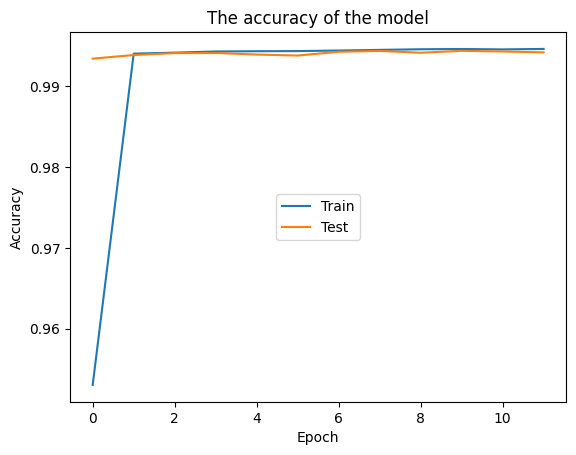

In [28]:
plt.plot(show_training_process.history['accuracy'])
plt.plot(show_training_process.history['val_accuracy'])
plt.title('The accuracy of the model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='center')
plt.show()

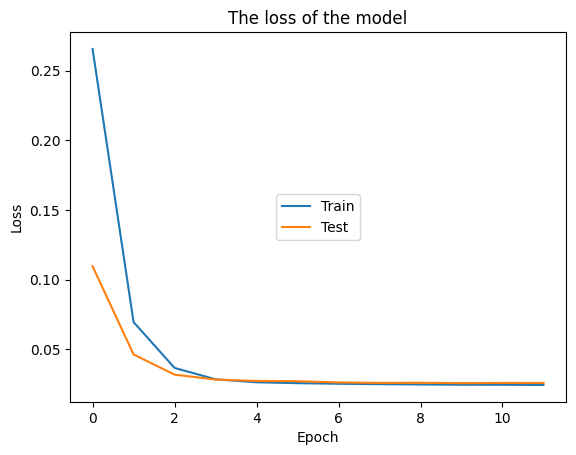

In [29]:
plt.plot(show_training_process.history['loss'])
plt.plot(show_training_process.history['val_loss'])
plt.title('The loss of the model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='center')
plt.show()

In [30]:
model.evaluate(inputs_test, output_test)[1] #get the best accuracy on the test set

5404/5404 [==============================] - 9s 2ms/step - loss: 0.0262 - accuracy: 0.9943


0.9942975640296936

In [ ]:
#for second encoding variant
#
#pred = model.predict(inputs_test)
#pred = np.argmax(pred,axis=1)
#output_eval = np.argmax(output_test,axis=1)
#score = metrics.accuracy_score(output_eval, pred)
#print("Validation score: {}".format(score))

In [31]:
pd.set_option('display.max_rows', 99999)
pd.set_option('display.max_colwidth', 400)
#pd.describe_option('max_colwidth')

display.max_colwidth : int
pd.DataFrame(np.argmin(model.predict(inputs_test), axis=-1))

5404/5404 [==============================] - 8s 1ms/step


,0
0,0
1,0
2,0
3,0
4,0
...,...
172903,0
172904,0
172905,0
172906,0


In [32]:
pd.set_option('display.max_rows', 99999)
pd.set_option('display.max_colwidth', 400)
#pd.describe_option('max_colwidth')

display.max_colwidth : int
output_test #print out the test set for Output Possibilities


,Output Possibilities
6558,0
356894,1
130639,1
225655,1
13557,0
...,...
229660,1
411170,1
164158,1
109452,1


In [33]:
output_test.value_counts() #print out the number of intrusions and normal connections detected in the test set


Output Possibilities
1                       138791
0                        34117
Name: count, dtype: int64

In [34]:
import matplotlib.pyplot as plt
x=output_test.value_counts()[1]
y=output_test.value_counts()[0]

def graph2(set):
    x=output_test.value_counts()[1]
    y=output_test.value_counts()[0]
    labels = 'intrusion', 'non-intrusion'
    sections = [x, y]
    colors = ['r', 'g']

    plt.pie(sections, labels=labels, colors=colors,
           startangle=90,
           explode = (0.1, 0.1),
           autopct = '%1.f%%') #how precise the percentage's going to be

    plt.axis('equal')
    plt.title('Detected Outputs in Test Set')
    plt.show()

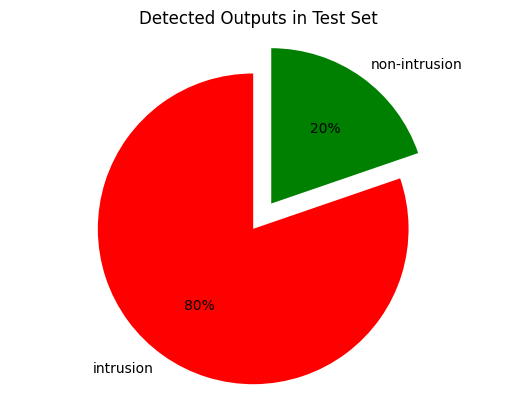

In [35]:
graph2(output_test)

In [36]:
from google.colab import files
from IPython.display import Image

uploaded = files.upload()

Saving finalloss.png to finalloss.png
Saving finalaccuracy.png to finalaccuracy.png
Saving optimalmodelaccuracy.png to optimalmodelaccuracy.png
Saving optimalmodelloss.png to optimalmodelloss.png
Saving neuralnetworkmodel.png to neuralnetworkmodel.png
Saving data.png to data.png
Saving modelloss_split0,95.png to modelloss_split0,95.png
Saving modelaccuracy_split0,95.png to modelaccuracy_split0,95.png
Saving modelloss_split0,85.png to modelloss_split0,85.png
Saving modelaccuracy_split0,85.png to modelaccuracy_split0,85.png
Saving modelloss_split0,75.png to modelloss_split0,75.png
Saving modelaccuracy_split0,75.png to modelaccuracy_split0,75.png
Saving modelloss_split0,65.png to modelloss_split0,65.png
Saving modelaccuracy_split0,65.png to modelaccuracy_split0,65.png
Saving modelloss_split0,55.png to modelloss_split0,55.png
Saving modelaccuracy_split0,55.png to modelaccuracy_split0,55.png
Saving modelloss_split0,45.png to modelloss_split0,45.png
Saving modelaccuracy_split0,45.png to mode

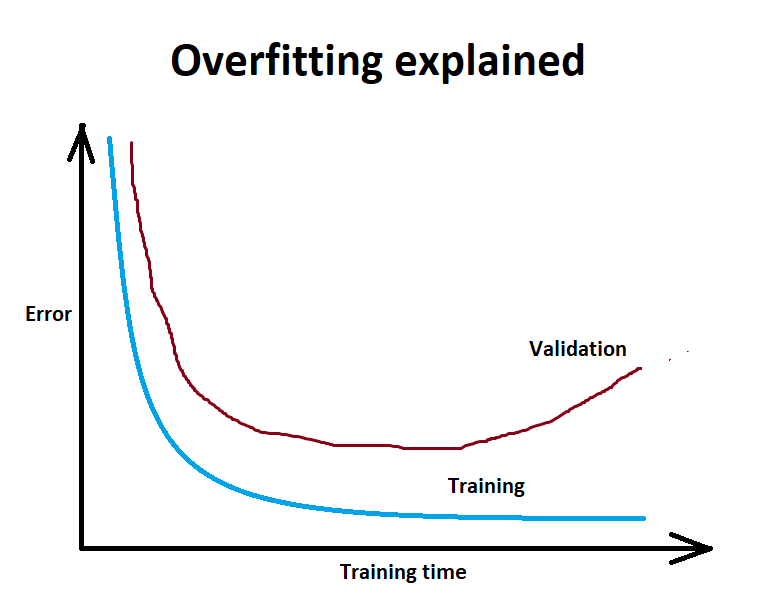

In [37]:
Image('Overfitting.png')